# 🎯 Predicting EPF Dividend Rates

This notebook aims to identify and analyze potential features for building a **multilinear regression model** to predict **EPF (Employees Provident Fund of Malaysia) annual dividend rates**.

### 🏦 Employees Provident Fund (EPF) – Overview

The Employees Provident Fund (EPF) is Malaysia’s national retirement savings scheme, established in 1951 to help employees in the private and non-pensionable public sectors build retirement savings. Funded by mandatory contributions from both employees and employers, EPF manages over RM1 trillion in assets on behalf of more than 15 million members.

EPF follows a long-term, prudent investment strategy focused on capital preservation, stable income generation, and sustainable growth. Its portfolio is diversified across key asset classes: fixed income (around 45–50%), equities (around 40%), and real assets like property and infrastructure (around 5–10%). A portion of funds is kept in liquid money market instruments for operational flexibility.

Since the early 2000s, EPF has increasingly invested abroad, with about 38% of total assets now held internationally. This global diversification has helped EPF consistently deliver annual dividends of around 5–6%, outperforming inflation and local fixed deposit rates—even during volatile periods.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import yfinance as yf
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.ar_model import AutoReg
import joblib
# from curl_cffi import requests

In [ ]:
# Data for EPF asset allocation
data = {
    'Asset Class': ['Fixed Income', 'Equities', 'Real Estate & Infrastructure', 'Money Market'],
    'Allocation (%)': [48, 40, 8, 4]
}

allocation_df = pd.DataFrame(data)

# Create interactive pie chart
fig = px.pie(allocation_df, names='Asset Class', values='Allocation (%)',
             title='EPF Malaysia – Strategic Asset Allocation (Approx.)')

fig.show()

In [ ]:
# Load from CSV
epfrate_df = pd.read_csv("epf_dividend_rates.csv")
epfrate_df.T

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
Year,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,...,1976-1978,1974-1975,1972-1973,1971,1968-1970,1965-1967,1964,1963,1960-1962,1952-1959
Simpanan Konvensional,6.3,5.5,5.35,6.1,5.2,5.45,6.15,6.9,5.7,6.4,...,7.0,6.6,5.85,5.8,5.75,5.5,5.25,5.0,4.0,2.5
Simpanan Shariah,6.3,5.4,4.75,5.65,4.9,5.0,5.9,6.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Function to expand year ranges
def expand_year_ranges(df):
    expanded_rows = []

    for _, row in df.iterrows():
        year_str = str(row['Year'])
        # Check if the year is a range (e.g., '1952-1959')
        if re.match(r'^\d{4}-\d{4}$', year_str):
            start_year, end_year = map(int, year_str.split('-'))
            for year in range(start_year, end_year + 1):
                new_row = row.copy()
                new_row['Year'] = year
                expanded_rows.append(new_row)
        else:
            # For single years, just append the row
            new_row = row.copy()
            # Ensure the year is an integer
            try:
                new_row['Year'] = int(year_str)
            except ValueError:
                # Handle cases where the year is not a valid integer
                continue
            expanded_rows.append(new_row)

    # Create a new DataFrame from the expanded rows
    expanded_df = pd.DataFrame(expanded_rows)

    # Sort the DataFrame by Year in descending order
    expanded_df.sort_values(by='Year', ascending=False, inplace=True)

    # Reset the index
    expanded_df.reset_index(drop=True, inplace=True)

    return expanded_df

# Apply the function to expand year ranges
epfrate_df_expanded = expand_year_ranges(epfrate_df)

epfrate_df_expanded.set_index("Year", inplace=True)

# Display the expanded DataFrame
epfrate_df_expanded.T

Year,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,...,1961,1960,1959,1958,1957,1956,1955,1954,1953,1952
Simpanan Konvensional,6.3,5.5,5.35,6.10,5.2,5.45,6.15,6.9,5.7,6.4,...,4.0,4.0,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
Simpanan Shariah,6.3,5.4,4.75,5.65,4.9,5.00,5.90,6.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


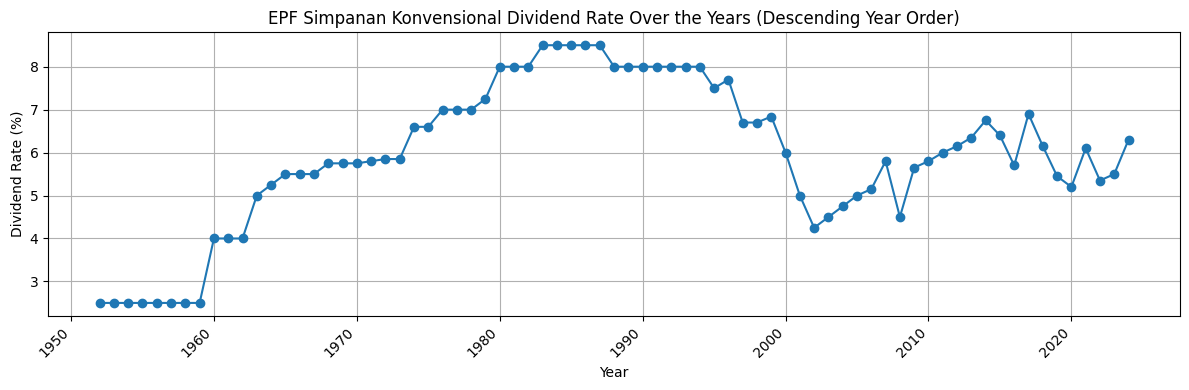

In [ ]:
# Clean and prepare data
plot_df = epfrate_df_expanded[epfrate_df_expanded['Simpanan Konvensional'].notnull()].copy()
plot_df = plot_df[::-1]  # Reverse the order to have latest years on the left

# Plotting
plt.figure(figsize=(12, 4))
plot_df['Simpanan Konvensional'].plot(kind='line', marker='o')

plt.xlabel("Year")
plt.ylabel("Dividend Rate (%)")
plt.title("EPF Simpanan Konvensional Dividend Rate Over the Years (Descending Year Order)")
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Feature Overview
---

## 📊 Feature Categories

### 1. Macroeconomic Indicators

| Feature | Description |
|--------|-------------|
| **Malaysia GDP Growth (%)** | Economic performance indicator; impacts domestic market and earnings. |
| **Malaysia Inflation Rate (%)** | Affects real returns; EPF aims to outpace inflation. |
| **Overnight Policy Rate (OPR)** | Determines interest rate trends; influences bond returns. |
| **USD/MYR Exchange Rate** | Affects returns on international investments when converted back to MYR. |
| **KLCI Index Annual Return (%)** | Proxy for domestic stock market performance. |
| **MSCI World / S&P 500 Return (%)** | Reflects global equity market trends; relevant due to EPF’s foreign equity exposure. |
| **Crude Oil Prices (Brent, USD/barrel)** | Key to Malaysia’s economy and stock market behavior. |

---

### 2. EPF Portfolio Indicators *(if available)*

| Feature | Description |
|--------|-------------|
| **Total Investment Income (RM)** | EPF's declared income from all asset classes; direct driver of dividend payout. |
| **Equity Allocation (%)** | Higher equity exposure typically implies greater return potential (and risk). |
| **Fixed Income Allocation (%)** | Indicates stability and predictability of returns. |
| **Real Estate & Infrastructure Allocation (%)** | Long-term stable cash flow contributor. |
| **Dividend Income (RM)** | Direct cash return from equity holdings. |
| **Malaysian Government Securities (MGS) Yield (%)** | Benchmark for fixed income returns. |

---

### 3. Policy & Behavioral Factors

| Feature | Description |
|--------|-------------|
| **EPF Statutory Contribution Rate (%)** | Can affect investable capital and cash flow. |
| **Withdrawal Programs (Dummy Variable)** | E.g., i-Lestari, i-Citra — may reduce investable funds. |
| **Net Contribution Inflow (RM)** | Indicates net liquidity pressure or surplus. |

---

### 4. Lagged Variables

Including lagged versions of key features may improve predictive performance:

- **Previous Year’s EPF Dividend Rate**
- **Previous Year’s KLCI / MSCI Returns**
- **Previous Year’s GDP Growth / Inflation**

These can capture delayed economic and investment effects.

---

### ✅ Modeling Notes

- Data should be **annual**, matching EPF’s dividend declaration cycle.
- Ensure normalization or standardization across features.
- Check for **multicollinearity** among economic indicators.
- Use **feature selection** or **regularization** (Lasso, Ridge) for optimal performance.

---

*Next step: collect data, preprocess, and start exploratory data analysis (EDA)!*

## Exploratory Data Analysis
### Macroeconomic Indicators

In [ ]:
# 📥 Load Malaysia GDP Annual Growth Data
df_gdp = pd.read_csv("gdp_annual.csv")

# Display the first few rows
df_gdp.head(10).T

,0,1,2,3,4,5,6,7,8,9
series,abs,abs,abs,abs,abs,abs,abs,abs,abs,abs
date,1970-01-01,1971-01-01,1972-01-01,1973-01-01,1974-01-01,1975-01-01,1976-01-01,1977-01-01,1978-01-01,1979-01-01
gdp,73709.682,81106.199,88720.81,99102.104,107346.073,108205.988,120718.377,130077.743,138732.976,151703.26
gni,76983.205,83746.673,91918.37,101584.245,109385.703,111851.757,123838.235,133193.374,141107.227,154006.765
gdp_capita,6773.39,7265.66,7751.699,8455.832,8941.871,8798.552,9589.923,10082.193,10509.519,11223.58
gni_capita,7074.204,7503.945,8032.858,8667.553,9117.128,9090.682,9837.771,10327.015,10688.523,11394.333


In [ ]:
## Exploring where abs ends
df_gdp.rename(columns={'date': 'Year'}, inplace=True)
df_gdp['Year'] = pd.to_datetime(df_gdp['Year']).dt.year
df_gdp.set_index('Year', inplace=True)
df_gdp[:60].T

Year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2020,2021,2022,2023,2024,1971,1972,1973,1974,1975
series,abs,abs,abs,abs,abs,abs,abs,abs,abs,abs,...,abs,abs,abs,abs,abs,growth_yoy,growth_yoy,growth_yoy,growth_yoy,growth_yoy
gdp,73709.682,81106.199,88720.81,99102.104,107346.073,108205.988,120718.377,130077.743,138732.976,151703.26,...,1346249.0,1390882.0,1514139.0,1567974.0,1648163.0,10.035,9.388,11.701,8.319,0.801
gni,76983.205,83746.673,91918.37,101584.245,109385.703,111851.757,123838.235,133193.374,141107.227,154006.765,...,1332466.0,1370015.0,1484034.0,1543076.0,1616334.0,8.786,9.758,10.516,7.68,2.254
gdp_capita,6773.39,7265.66,7751.699,8455.832,8941.871,8798.552,9589.923,10082.193,10509.519,11223.58,...,41490.0,42696.149,46306.6,46942.732,48391.738,7.268,6.69,9.084,5.748,-1.603
gni_capita,7074.204,7503.945,8032.858,8667.553,9117.128,9090.682,9837.771,10327.015,10688.523,11394.333,...,41065.0,42055.591,45385.905,46197.324,47457.207,6.075,7.048,7.901,5.187,-0.29


In [ ]:
## Checking if those abs' correspond to different years (yes if 55)
df_gdp.index[0:55].nunique()

55

### Overnight Policy Rate (OPR)

In [ ]:
# Load the OPR data
## https://financialmarkets.bnm.gov.my/data-download-opr
df_opr = pd.read_csv('opr_data.csv')  # Replace with your actual file path

df_opr['Date'] = pd.to_datetime(df_opr['Date'], format='%d/%m/%Y')
df_opr.sort_values(by='Date', inplace=True)

df_opr['Date'] = pd.to_datetime(df_opr['Date'], format='%d/%m/%Y').dt.date
df_opr.set_index('Date', inplace=True)

# Display the first few rows
df_opr.head(20).T

Date,2004-05-26,2004-08-25,2004-11-30,2005-02-28,2005-05-25,2005-08-24,2005-11-30,2005-12-15,2006-01-20,2006-02-22,2006-04-26,2006-05-22,2006-07-28,2006-08-25,2006-09-26,2006-11-24,2007-01-26,2007-02-26,2007-04-27,2007-05-28
Rate,2.7,2.7,2.7,2.7,2.7,2.7,3.0,3.0,3.0,3.25,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5,3.5


In [ ]:
## Extract the last rate for each year
# Step 1: Ensure the index is datetime
df_opr.index = pd.to_datetime(df_opr.index)

# Step 2: Extract year from index
df_opr['Year'] = df_opr.index.year

# Step 3: Get last entry of each year
df_opr_year = df_opr.groupby('Year')['Rate'].last().to_frame()

# Step 4: Optional – ensure 'Year' is the index name
df_opr_year.index.name = 'Year'
df_opr_year.rename(columns={'Rate': 'opr_rate'}, inplace=True)

# Preview
df_opr_year.T

Year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
opr_rate,2.7,3.0,3.5,3.5,3.25,2.0,2.75,3.0,3.0,3.0,...,3.25,3.0,3.0,3.25,3.0,1.75,1.75,2.75,3.0,3.0


### USD/MYR Exchange Rate (middle rate at 12 pm)

In [ ]:
# Load only the 'Date' and 'USD' columns
df_fx = pd.read_csv('fx.csv', usecols=['Date', 'USD'])

# Parse 'Date' column (e.g., "2 Jan 2004") and strip time
df_fx['Date'] = pd.to_datetime(df_fx['Date'], dayfirst=True).dt.date

# Set 'Date' as the index
df_fx.set_index('Date', inplace=True)

# Preview the result
df_fx.head().T

Date,2004-01-02,2004-01-05,2004-01-06,2004-01-07,2004-01-08
USD,3.8,3.8,3.8,3.8,3.8


In [ ]:
## Preparing the data for regression
# Ensure the index is datetime
df_fx.index = pd.to_datetime(df_fx.index)

# Create an empty DataFrame to store results
df_fx_year = pd.DataFrame(columns=['fx_median', 'fx_trend'])

# Loop over unique years
for year in df_fx.index.year.unique():
    # Filter data for Q4 (Oct-Dec) of the current year
    q4 = df_fx[(df_fx.index.year == year) & (df_fx.index.month >= 10)]

    if len(q4) >= 2:  # Need at least 2 points for regression
        # Median value
        median_fx = q4['USD'].median()

        # Prepare data for linear regression
        # Use ordinal days or sequence numbers as x
        x = np.arange(len(q4)).reshape(-1, 1)
        y = q4['USD'].values.reshape(-1, 1)

        model = LinearRegression()
        model.fit(x, y)
        slope = model.coef_[0][0]  # Extract slope (trend)

        # Assign to new DataFrame
        df_fx_year.loc[year] = [median_fx, slope]

# Make sure index is named 'Year'
df_fx_year.index.name = 'Year'

# Preview
df_fx_year.T

Year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
fx_median,3.800000e+00,3.777500,3.644500,3.354250,3.552750,3.393000,3.109250,3.156000,3.057500,3.204000,...,4.291000,4.342000,4.185250,4.177500,4.171600,4.110150,4.180750,4.581500,4.684500,4.426250
fx_trend,-8.198345e-33,0.000133,-0.002903,-0.001026,0.000563,0.000103,0.000631,0.000544,-0.000052,0.001609,...,0.000148,0.006929,-0.003488,0.000461,-0.000896,-0.002243,0.000988,-0.006643,-0.001956,0.004064


### KLCI Index Annual Return (\%)

In [ ]:
klci = pd.read_csv('klci_raw.csv')
klci.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2003-12-01 00:00:00+08:00,779.239990,792.190002,778.400024,790.559998,790.559998,60007200,0.0,0.0
1,2003-12-02 00:00:00+08:00,793.520020,797.969971,792.679993,797.799988,797.799988,56750600,0.0,0.0
2,2003-12-03 00:00:00+08:00,797.510010,797.510010,793.320007,795.570007,795.570007,48928600,0.0,0.0
3,2003-12-04 00:00:00+08:00,795.330017,795.409973,786.780029,790.130005,790.130005,44134400,0.0,0.0
4,2003-12-05 00:00:00+08:00,789.460022,790.030029,786.880005,786.979980,786.979980,50002600,0.0,0.0


In [ ]:
# Convert "Date" to datetime if it's not already
klci['Date'] = pd.to_datetime(klci['Date'])

# Remove the time part (keep only the date)
klci['Date'] = klci['Date'].dt.date

# Set "Date" as the index
klci.set_index('Date', inplace=True)

klci.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2003-12-01,779.239990,792.190002,778.400024,790.559998,790.559998,60007200,0.0,0.0
2003-12-02,793.520020,797.969971,792.679993,797.799988,797.799988,56750600,0.0,0.0
2003-12-03,797.510010,797.510010,793.320007,795.570007,795.570007,48928600,0.0,0.0
2003-12-04,795.330017,795.409973,786.780029,790.130005,790.130005,44134400,0.0,0.0
2003-12-05,789.460022,790.030029,786.880005,786.979980,786.979980,50002600,0.0,0.0


In [ ]:
# Convert index back to datetime (required for resample)
klci.index = pd.to_datetime(klci.index)

# Resample to year-end closing prices
annual_close = klci['Adj Close'].resample('YE').last()

# Calculate annual return in %
annual_return = annual_close.pct_change() * 100

# Convert to DataFrame if necessary
if isinstance(annual_return, pd.DataFrame):
    annual_return_df = annual_return
    annual_return_df.columns = ['KLCI Annual Return (%)']
else:
    annual_return_df = pd.DataFrame({
        'KLCI Annual Return (%)': annual_return
    })

# Set index to year only
annual_return_df.index = annual_return_df.index.year

# Drop the first NaN
annual_return_df.dropna(inplace=True)

# Final output
klci_ar = annual_return_df
klci_ar.T

Date,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
KLCI Annual Return (%),14.29453,-0.84194,21.832874,31.816942,-39.32652,45.170234,19.337985,0.778186,10.336243,10.539685,...,-3.902909,-3.000279,9.446138,-5.91215,-6.022782,2.420123,-3.667623,-4.595768,-2.730206,12.581635


### MSCI World / S&P 500 Return (\%)

In [ ]:
# Load the CSV file (S&P annual returns)
snp = pd.read_csv("snp_raw.csv", index_col=0)

# If the index is not already integers (years), convert it
snp.index = snp.index.astype(int)

# Transpose for viewing
snp.T

Date,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
S&P 500,8.993452,3.001023,13.619432,3.529573,-38.485793,23.45419,12.782714,-0.003184,13.405691,29.60125,...,9.535023,19.419966,-6.23726,28.87807,16.258923,26.892739,-19.442827,24.230501,23.309002,-3.701184


### Crude Oil Prices (Brent, USD/barrel)

In [ ]:
brent_returns = pd.read_csv('brent_returns.csv', index_col="Date")
brent_returns.T

Date,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
BZ=F,82.546111,98.94524,63.574444,80.36472,110.989333,111.715679,108.673581,99.28432,53.502262,45.16008,54.726016,71.767171,64.160635,43.086759,70.953809,98.966335,82.190438,79.82131,71.872697


### EPF Investment Data

In [ ]:
epf_investment = pd.read_csv('epf_investment.csv', index_col="Year")
epf_investment.T

Year,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Investment,25.0,28.0,31.0,36.0,41.0,47.0,53.0,63.0,73.0,86.0,...,685.0,731.0,791.0,834.0,925.0,1000.0,1010.0,1003.0,1136.0,1250.0


In [ ]:
fig = px.line(
    epf_investment,
    x=epf_investment.index,
    y='Investment',
    title='EPF Investment Assets Over Time (1985–2024)',
    markers=True,
    labels={'Investment': 'Investment (RM Billion)'}
)
fig.update_layout(xaxis_title='Year', yaxis_title='Investment (RM Billion)')
fig.show()

## Preliminary Regression for EPF Rates

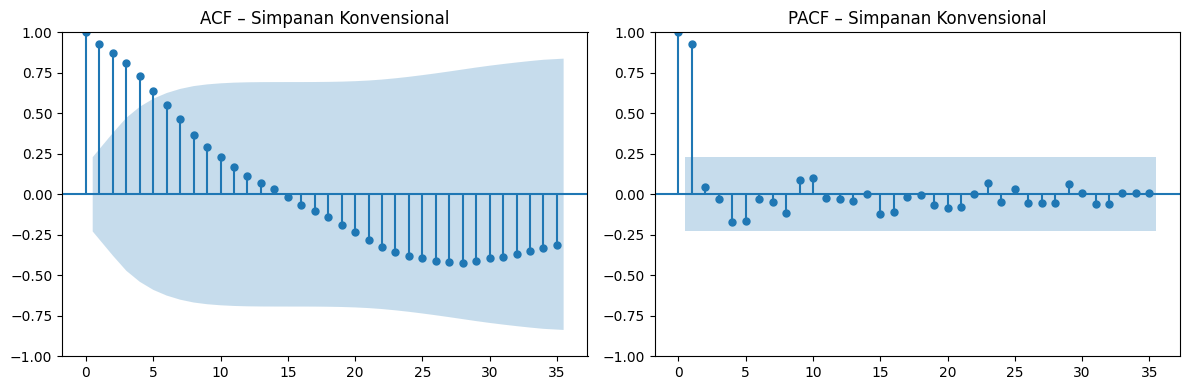

In [ ]:
# Drop missing values
series_k = epfrate_df_expanded['Simpanan Konvensional'].dropna()

# Set appropriate lag based on sample size
max_lag_k = len(series_k) // 2 - 1

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(series_k, lags=max_lag_k, ax=axes[0])
axes[0].set_title('ACF – Simpanan Konvensional')

plot_pacf(series_k, lags=max_lag_k, ax=axes[1])
axes[1].set_title('PACF – Simpanan Konvensional')

plt.tight_layout()
plt.show()

### 🔍 1. ACF Plot – Autocorrelation Function
What it shows: Correlation of the series with its own lags (e.g., current year vs. 1 year ago, 2 years ago, etc.).

Interpretation:

- The first few lags (up to lag 5) show strong positive autocorrelation — the values are significantly above the shaded confidence interval (blue zone).

- After lag 6 or so, the autocorrelations decline and mostly fall inside the confidence band → suggests diminishing influence from older years.

🧠 This implies: EPF returns (Simpanan Konvensional) are strongly correlated with recent years, but that correlation weakens over time.

### 🔍 2. PACF Plot – Partial Autocorrelation Function
What it shows: The direct effect of a lag, after removing the effects of intervening lags.

Interpretation:

- Lag 1 is very high → strong direct relationship between current and previous year’s rate.

- Lag 2 is also significant, but other lags are mostly within the blue zone → not strongly significant.

🧠 This implies: You could model this series with an AR(1) or AR(2) process (AutoRegressive), where current values depend primarily on the last 1–2 years.

In [ ]:
epfrate_df_expanded['Simpanan Konvensional'].T

,Simpanan Konvensional
Year,
2024,6.30
2023,5.50
2022,5.35
2021,6.10
2020,5.20
...,...
1956,2.50
1955,2.50
1954,2.50


In [ ]:
## Shifting "down" target by a year for cross-sectional regression analysis
## Example: Rate for 2024 is 6.3; to move that rate down to 2023
# Step 1: Create a new DataFrame using the same index (already 'Year')
target_df = pd.DataFrame(index=epfrate_df_expanded.index.copy())

# Step 2: Add shifted target
target_df['conv'] = epfrate_df_expanded['Simpanan Konvensional'].shift(1)

# Step 3: Drop rows with NaN (e.g. last year has no next-year target)
target_df.dropna(inplace=True)
target_df = target_df.sort_index()  # ascending order

# Preview
target_df.T

Year,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
conv,2.5,2.5,2.5,2.5,2.5,2.5,2.5,4.0,4.0,4.0,...,6.4,5.7,6.9,6.15,5.45,5.2,6.1,5.35,5.5,6.3


# Multilinear Regression

## MODEL 1: MULTILINEAR REGRESSION WITH FULL FEATURES `features`

In [ ]:
features = pd.concat([
    df_gdp[['gdp', 'gni', 'gdp_capita', 'gni_capita']].iloc[:55],
    df_opr_year[['opr_rate']],
    df_fx_year[['fx_median', 'fx_trend']],
    klci_ar[['KLCI Annual Return (%)']],
    snp[['S&P 500']],
    epf_investment['Investment']
], axis=1, join='inner')

NameError: name 'pd' is not defined

In [ ]:
# Create sets of years from the index of each DataFrame
years_gdp = set(df_gdp.iloc[:55].index)
years_opr = set(df_opr_year.index)
years_fx = set(df_fx_year.index)
years_klci = set(klci_ar.index)
years_snp = set(snp.index)
years_epf = set(epf_investment.index)

# Get the intersection of all years
common_years = years_gdp & years_opr & years_fx & years_klci & years_snp & years_epf

# Optionally sort the years
common_years = sorted(common_years)

print("Common years across all features:")
print(common_years)

NameError: name 'df_gdp' is not defined

In [ ]:
# Check the index type and contents
print("Index dtype:", target_df.index.dtype)
print("Index sample:", target_df.index[:5])

# Check for NaNs in the target data
nan_count = target_df.isna().sum()

print("\nNaN count in target_df:")
print(nan_count)

# Optional: Show any rows with missing target values
if nan_count.any():
    print("\nRows with NaN in target_df:")
    print(target_df[target_df.isna().any(axis=1)])
else:
    print("\n✅ No NaN values in target_df.")

In [ ]:
features_20042024 = features.loc[common_years]

### MODEL 1.1 Full `features`; *no* 80/20 train/test split.

In [ ]:
# Make sure both features and target are aligned on years
X = features_20042024.loc[features_20042024.index <= 2023]
y = target_df.loc[X.index]

# Confirm shapes match
assert X.shape[0] == y.shape[0], "Mismatch in number of rows between features and target."

# Initialize and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict on the same data
y_pred = model.predict(X)

# Optional: Evaluate
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

In [ ]:
# Extract 2024 row from features
X_2024 = features_20042024.loc[[2024]]  # Double brackets to keep it as a DataFrame

# Predict
y_2024_pred = model.predict(X_2024)

In [ ]:
print("MODEL 1.1 PREDICTION PERFORMANCE:")
print(f"Predicted value for 2025 (%):\n {np.squeeze(y_2024_pred):.4f}")
print(f"Actual Dividend (%):\n 6.30")
print(f"Difference (%) [Actual - Predicted]:\n {(6.30-np.squeeze(y_2024_pred)):.2f}")

MODEL 1.1 PREDICTION PERFORMANCE:


NameError: name 'np' is not defined

### MODEL 1.2 Full `features`; *with* 80/20 train/test split.

In [ ]:
import joblib

# Prepare features and target (up to 2023 only)
X = features_20042024.loc[features_20042024.index <= 2023]
y = target_df.loc[X.index]

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23
)

# Fit the model
model_1v2 = LinearRegression()
model_1v2.fit(X_train, y_train)

# Predict on test set
y_pred = model_1v2.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score (test): {r2:.4f}")
print(f"Mean Squared Error (test): {mse:.4f}")
print(f"Mean Absolute Error (test): {mae:.4f}")

# Save model
joblib.dump(model_1v2, "model_1v2.pkl")

In [ ]:
# Extract 2024 features
X_2024 = features_20042024.loc[[2024]]

# Predict
y_2024_pred = model_1v2.predict(X_2024)

# Print nicely
print("MODEL 1.2 PREDICTION PERFORMANCE:")
print(f"Predicted value for 2025 (%):\n {np.squeeze(y_2024_pred):.4f}")
print(f"Actual Dividend (%):\n 6.30")
print(f"Difference (%) [Actual - Predicted]:\n {(6.30 - np.squeeze(y_2024_pred)):.2f}")

### MODEL 1.3 Full `features`; with training from 2004-2020.

In [ ]:
# Split features and target by year
X_train = features_20042024.loc[features_20042024.index <= 2020]
y_train = target_df.loc[X_train.index]

X_test = features_20042024.loc[(features_20042024.index >= 2021) & (features_20042024.index <= 2023)]
y_test = target_df.loc[X_test.index]

# Train the model
model_1v3 = LinearRegression()
model_1v3.fit(X_train, y_train)

# Predict on test set
y_pred = model_1v3.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score (2021–2023): {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Save model
joblib.dump(model_1v3, "model_1v3.pkl")

In [ ]:
# Create a DataFrame for comparison
results_1v3 = pd.DataFrame({
    'Actual (%)': y_test.values.flatten(),
    'Predicted (%)': np.squeeze(y_pred)
}, index=y_test.index+1)

# Add a column for the difference
results_1v3['Difference (Actual - Predicted) (%)'] = results_1v3['Actual (%)'] - results_1v3['Predicted (%)']

# Display
print("Predicted vs. Actual for 2022–2024:")
results_1v3.round(2)

In [ ]:
# Extract 2024 features
X_2024 = features_20042024.loc[[2024]]

# Predict
y_2024_pred = model_1v3.predict(X_2024)

# Print results
print("MODEL 1.3 PREDICTION PERFORMANCE:")
print(f"Predicted value for 2025 (%):\n {np.squeeze(y_2024_pred):.4f}")
print(f"Actual Dividend (%):\n 6.30")
print(f"Difference (%) [Actual - Predicted]:\n {(6.30 - np.squeeze(y_2024_pred)):.2f}")

In [ ]:
# Data
models = ['Model 1.1', 'Model 1.2', 'Model 1.3']
predictions = [6.4864, 5.9809, 5.6214]
differences = [6.30 - pred for pred in predictions]  # Predicted - Actual

x = np.arange(len(models))  # Bar positions

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot predictions
bar1 = ax1.bar(x - 0.2, predictions, width=0.4, label='Predicted (%)', color='skyblue')
ax1.set_ylabel('Dividend (%)')
ax1.set_ylim(5.0, 7.0)
ax1.axhline(y=6.30, color='red', linestyle='--', linewidth=1.5, label='Actual = 6.30%')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
plt.legend(loc='upper left')

# Create secondary axis for differences
ax2 = ax1.twinx()
bar2 = ax2.bar(x + 0.2, differences, width=0.4, label='Difference (Pred - Actual)', color='orange')
ax2.set_ylabel('Difference from Actual (%)')
# plt.legend(loc='upper lower left')

# Title and layout
plt.title('Predicted vs Actual Dividend (2024) – Models 1.1 to 1.3')
plt.tight_layout()

# Add value labels
for i, rect in enumerate(bar1):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 0.02, f'{height:.2f}', ha='center')

for i, rect in enumerate(bar2):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 0.01*np.sign(height), f'{height:.2f}', ha='center')

# Show plot
plt.show()

NameError: name 'np' is not defined

# Investigating Correlations with Target

In [ ]:
# Combine features into one DataFrame (as you've done)
features = pd.concat([
    df_gdp[['gdp', 'gni', 'gdp_capita', 'gni_capita']].iloc[:55],
    df_opr_year[['opr_rate']],
    df_fx_year[['fx_median', 'fx_trend']],
    klci_ar[['KLCI Annual Return (%)']],
    snp[['S&P 500']],
    epf_investment['Investment']
], axis=1, join='inner')

# Make sure the target aligns in index with the features
target = target_df.loc[features.index[:-1]]

# Concatenate for correlation
full_df = pd.concat([features, target], axis=1)

# Compute correlation matrix
corr_matrix = full_df.corr()

# Extract correlation of each feature with the target
target_name = target.columns[0]  # assuming target_df has only one column
feature_target_corr = corr_matrix[[target_name]].drop(target_name)

# Optional: Sort by absolute correlation strength
feature_target_corr['abs_corr'] = feature_target_corr[target_name].abs()
feature_target_corr = feature_target_corr.sort_values('abs_corr', ascending=False).drop(columns='abs_corr')

# Display
feature_target_corr.T

,fx_trend,S&P 500,Investment,gdp,gni,gdp_capita,gni_capita,KLCI Annual Return (%),fx_median,opr_rate
conv,0.386574,0.249318,0.244412,0.241168,0.219617,0.214995,0.180447,-0.111905,-0.0885,-0.030115


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1124: UserWarning:

``square=True`` ignored in clustermap



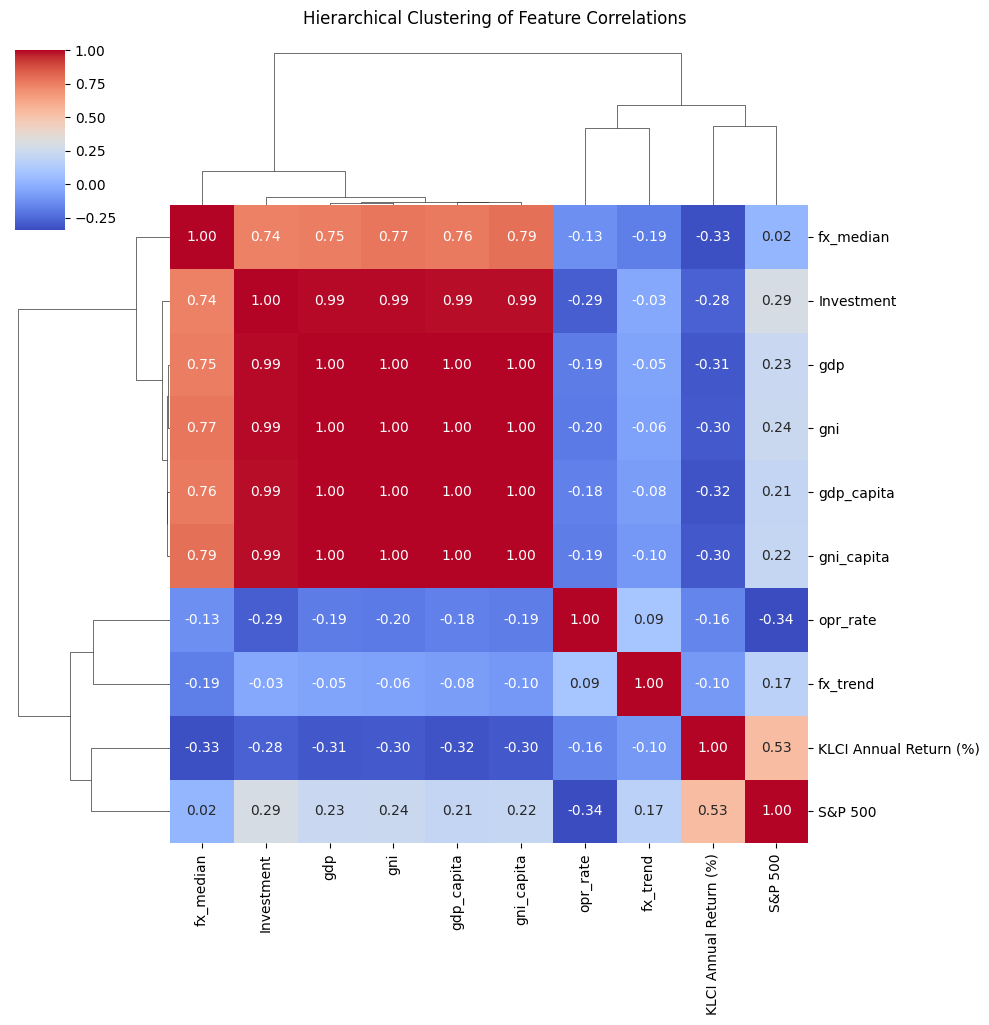

In [ ]:
# Step 2: Compute correlation matrix
corr_matrix_full = features.corr()

# Step 4: Plot clustermap for multicollinearity
sns.clustermap(
    corr_matrix_full,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    figsize=(10, 10),
    square=True
)

plt.suptitle("Hierarchical Clustering of Feature Correlations", y=1.02)
plt.show()

### Narrowing Down the Set of Features

In [ ]:
reduced_features = features[[
    'gdp_capita',           # Chosen GDP proxy
    'opr_rate',
    'fx_trend',
    'fx_median',
    'KLCI Annual Return (%)',
    'S&P 500'
]]

The reduced feature set was selected to address multicollinearity while preserving economic and market diversity in the model. The heatmap revealed that `gdp`, `gni`, `gdp_capita`, `gni_capita`, and `Investment` are nearly perfectly correlated (correlation coefficients > 0.99), meaning they carry redundant information. To retain the signal while avoiding multicollinearity, only `gdp_capita`—a widely used and interpretable macroeconomic indicator—was kept as a representative of that group. The remaining features (`opr_rate`, `fx_trend`, `fx_median`, `KLCI Annual Return (%)`, and `S&P 500`) showed lower correlations with each other and the GDP cluster, offering distinct insights into monetary policy, currency behavior, and equity market trends. This selection ensures a more stable and interpretable regression model by balancing explanatory power with independence among predictors.

In [ ]:
# Add constant for intercept
from statsmodels.tools.tools import add_constant
X = add_constant(reduced_features)

# Compute VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_df

,feature,VIF
0,const,133.972979
1,gdp_capita,3.009730
2,opr_rate,1.178012
3,fx_trend,1.240974
4,fx_median,2.555004
5,KLCI Annual Return (%),2.186034
6,S&P 500,2.265370


The variance inflation factor (VIF) results for our selected features indicate that the model is well-structured and free from problematic multicollinearity. All predictors have VIF values below 4, which means they provide distinct, non-redundant information — a strong sign of model stability. The highest VIF, for GDP per capita, is just over 3, which is well within acceptable limits and reflects some natural overlap with other economic indicators. Other features like interest rates, exchange rate trends, and stock market returns show low VIFs, confirming they contribute unique insights. Overall, these results give us confidence that the model's predictors are statistically sound and won't distort or weaken the accuracy of our results.

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1124: UserWarning:

``square=True`` ignored in clustermap



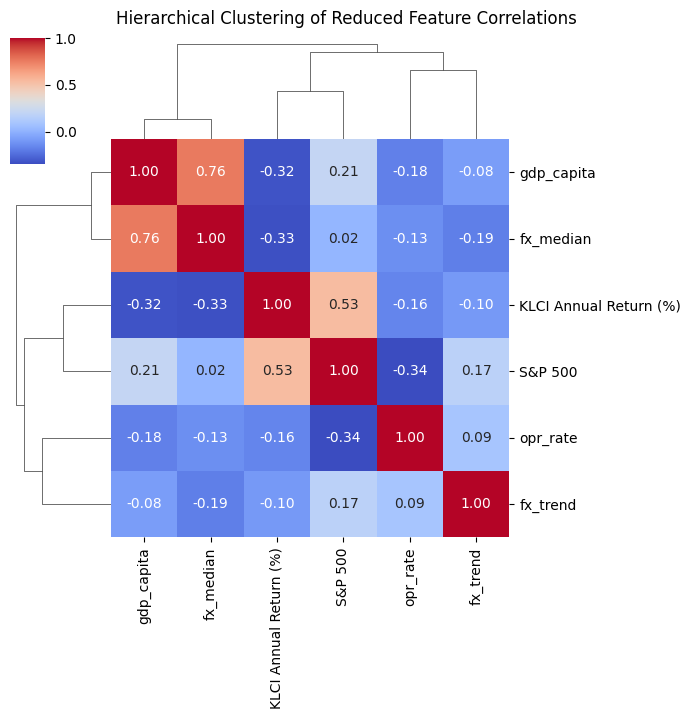

In [ ]:
# Step 2: Compute correlation matrix
corr_matrix_reduced = reduced_features.corr()

# Step 4: Plot clustermap for multicollinearity
sns.clustermap(
    corr_matrix_reduced,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    figsize=(7, 7),
    square=True
)

plt.suptitle("Hierarchical Clustering of Reduced Feature Correlations", y=1.02)
plt.show()

This correlation heatmap, enhanced with hierarchical clustering, visually confirms that the reduced feature set used in the model is well-balanced and minimally redundant. Most features exhibit low to moderate correlations with each other, which supports the statistical independence needed for robust predictive modeling. The strongest correlation observed is between GDP per capita and the median exchange rate (0.76), which is reasonable given both are macroeconomic indicators, but it's still below the threshold where multicollinearity becomes a concern. Other key variables — such as interest rates, KLCI and S&P 500 returns, and FX trend — show weak correlations with each other, highlighting that each brings a distinct perspective to the model. This clustering structure reassures us that the selected features are diverse in signal and well-suited for stable and interpretable regression analysis.

### MODEL 2.1 Reduced `features`; *no* 80/20 train/test split.

In [ ]:
redfeatures_20042024 = reduced_features.loc[common_years]

In [ ]:
# Make sure both features and target are aligned on years
X = redfeatures_20042024.loc[redfeatures_20042024.index <= 2023]
y = target_df.loc[X.index]

# Confirm shapes match
assert X.shape[0] == y.shape[0], "Mismatch in number of rows between features and target."

# Initialize and fit the model
model_2_1 = LinearRegression()
model_2_1.fit(X, y)

# Predict on the same data
y_pred = model_2_1.predict(X)

# Evaluate
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Save the model
joblib.dump(model_2_1, "model_2.1.pkl")

R² Score: 0.3454
Mean Squared Error: 0.2277
Mean Absolute Error: 0.3849


['model_2.1.pkl']

In [ ]:
# Extract 2024 row from features
X_2024 = redfeatures_20042024.loc[[2024]]  # Double brackets to keep it as a DataFrame

# Predict
y_2024_pred = model_2_1.predict(X_2024)

In [ ]:
print("MODEL 2.1 PREDICTION PERFORMANCE:")
print(f"Predicted value for 2025 (%):\n {np.squeeze(y_2024_pred):.4f}")
print(f"Actual Dividend (%):\n 6.30")
print(f"Difference (%) [Actual - Predicted]:\n {(6.30-np.squeeze(y_2024_pred)):.2f}")

MODEL 2.1 PREDICTION PERFORMANCE:
Predicted value for 2025 (%):
 6.5624
Actual Dividend (%):
 6.30
Difference (%) [Actual - Predicted]:
 -0.26


### MODEL 2.2 Reduced `features`; *with* 80/20 train/test split.

In [ ]:
# Prepare features and target (up to 2023 only)
X = redfeatures_20042024.loc[redfeatures_20042024.index <= 2023]
y = target_df.loc[X.index]

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23
)

# Fit the model
model_2v2 = LinearRegression()
model_2v2.fit(X_train, y_train)

# Predict on test set
y_pred = model_2v2.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score (test): {r2:.4f}")
print(f"Mean Squared Error (test): {mse:.4f}")
print(f"Mean Absolute Error (test): {mae:.4f}")

# Save model
joblib.dump(model_2v2, "model_2v2.pkl")

R² Score (test): 0.5144
Mean Squared Error (test): 0.1508
Mean Absolute Error (test): 0.3480


['model_2v2.pkl']

In [ ]:
# Extract 2024 features
X_2024 = redfeatures_20042024.loc[[2024]]

# Predict
y_2024_pred = model_2v2.predict(X_2024)

# Print nicely
print("MODEL 2.2 PREDICTION PERFORMANCE:")
print(f"Predicted value for 2025 (%):\n {np.squeeze(y_2024_pred):.4f}")
print(f"Actual Dividend (%):\n 6.30")
print(f"Difference (%) [Actual - Predicted]:\n {(6.30 - np.squeeze(y_2024_pred)):.2f}")

MODEL 2.2 PREDICTION PERFORMANCE:
Predicted value for 2025 (%):
 6.5241
Actual Dividend (%):
 6.30
Difference (%) [Actual - Predicted]:
 -0.22


### MODEL 3.3 Reduced `features`; with training from 2004-2020.

In [ ]:
# Split features and target by year
X_train = redfeatures_20042024.loc[redfeatures_20042024.index <= 2020]
y_train = target_df.loc[X_train.index]

X_test = redfeatures_20042024.loc[(redfeatures_20042024.index >= 2021) & (redfeatures_20042024.index <= 2023)]
y_test = target_df.loc[X_test.index]

# Train the model
model_2v3 = LinearRegression()
model_2v3.fit(X_train, y_train)

# Predict on test set
y_pred = model_2v3.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score (2021–2023): {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Save model
joblib.dump(model_2v3, "model_2v3.pkl")

R² Score (2021–2023): -3.0742
Mean Squared Error: 0.7085
Mean Absolute Error: 0.7803


['model_2v3.pkl']

In [ ]:
# Create a DataFrame for comparison
results_2v3 = pd.DataFrame({
    'Actual (%)': y_test.values.flatten(),
    'Predicted (%)': np.squeeze(y_pred)
}, index=y_test.index+1)

# Add a column for the difference
results_2v3['Difference (Actual - Predicted) (%)'] = results_2v3['Actual (%)'] - results_2v3['Predicted (%)']

# Display
print("Predicted vs. Actual for 2022–2024:")
results_2v3.round(2)

Predicted vs. Actual for 2022–2024:


,Actual (%),Predicted (%),Difference (Actual - Predicted) (%)
2022,5.35,6.57,-1.22
2023,5.50,4.86,0.64
2024,6.30,5.82,0.48


In [ ]:
# Extract 2024 features
X_2024 = redfeatures_20042024.loc[[2024]]

# Predict
y_2024_pred = model_2v3.predict(X_2024)

# Print results
print("MODEL 2.3 PREDICTION PERFORMANCE:")
print(f"Predicted value for 2025 (%):\n {np.squeeze(y_2024_pred):.4f}")
print(f"Actual Dividend (%):\n 6.30")
print(f"Difference (%) [Actual - Predicted]:\n {(6.30 - np.squeeze(y_2024_pred)):.2f}")

MODEL 2.3 PREDICTION PERFORMANCE:
Predicted value for 2025 (%):
 6.4547
Actual Dividend (%):
 6.30
Difference (%) [Actual - Predicted]:
 -0.15


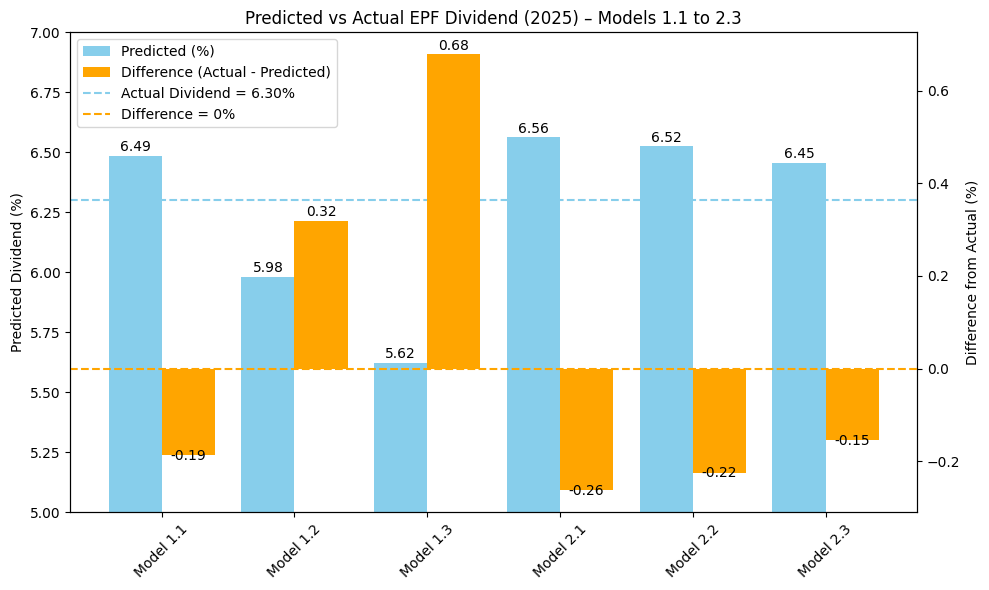

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Data
models = ['Model 1.1', 'Model 1.2', 'Model 1.3', 'Model 2.1', 'Model 2.2', 'Model 2.3']
predictions = [6.4864, 5.9809, 5.6214, 6.5624, 6.5241, 6.4547]
actual = 6.30
differences = [actual - pred for pred in predictions]

x = np.arange(len(models))  # Bar positions

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot predictions (left axis)
bar1 = ax1.bar(x - 0.2, predictions, width=0.4, color='skyblue')
ax1.set_ylabel('Dividend (%)')
ax1.set_ylim(5.0, 7.0)
ax1.axhline(y=actual, color='skyblue', linestyle='--', linewidth=1.5)

# X-axis ticks
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)

# Secondary axis for differences
ax2 = ax1.twinx()
bar2 = ax2.bar(x + 0.2, differences, width=0.4, color='orange')
ax2.set_ylabel('Difference from Actual (%)')
ax2.axhline(y=0, color='orange', linestyle='--', linewidth=1.5)

# Add value labels to predictions
for rect in bar1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 0.02, f'{height:.2f}', ha='center')

# Add value labels to differences
for rect in bar2:
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 0.01*np.sign(height), f'{height:.2f}', ha='center')

# Custom legend handles
custom_legend = [
    Patch(facecolor='skyblue', label='Predicted (%)'),
    Patch(facecolor='orange', label='Difference (Actual - Predicted)'),
    Line2D([0], [0], color='skyblue', linestyle='--', linewidth=1.5, label='Actual Dividend = 6.30%'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=1.5, label='Difference = 0%')
]

# Add combined legend
ax1.legend(handles=custom_legend, loc='upper left')

# Title and layout
plt.title('Predicted vs Actual EPF Dividend (2025) – Models 1.1 to 2.3')
plt.tight_layout()
plt.show()

# Time Series Analysis of EPF Dividends from 1952 to 2024

## AR(1) Model: Model 3.1

In [ ]:
# Ensure the index is a PeriodIndex with annual frequency
series = epfrate_df_expanded['Simpanan Konvensional']
series.index = pd.PeriodIndex(series.index, freq='Y')

# Sort index in ascending order (monotonic)
series = series.sort_index()

In [ ]:
# Fit AR(1) with updated index
ar_1 = AutoReg(series, lags=1, old_names=False).fit()

# Print summary
print(ar_1.summary())

# Save the model
joblib.dump(ar_1, "ar_1.pkl")

                              AutoReg Model Results                              
Dep. Variable:     Simpanan Konvensional   No. Observations:                   73
Model:                        AutoReg(1)   Log Likelihood                 -49.682
Method:                  Conditional MLE   S.D. of innovations              0.482
Date:                   Fri, 09 May 2025   AIC                            105.365
Time:                           08:42:37   BIC                            112.195
Sample:                       12-31-1953   HQIC                           108.084
                            - 12-31-2024                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.4697      0.205      2.290      0.022       0.068       0.872
Simpanan Konvensional.L1     0.9297      0.033     28.001      0.

['ar_1.pkl']

The AR(1) model fitted to the EPF Simpanan Konvensional series shows strong year-to-year persistence, with a statistically significant lag-1 coefficient of 0.93 and an intercept of 0.47. The model’s fit is moderate, with an AIC of 105.37 and standard error of 0.48, indicating average forecast deviation of around half a percentage point. However, the autoregressive root is slightly above 1 (1.0756), suggesting the series may exhibit mild non-stationarity, which can affect forecast reliability over longer horizons. While the model captures the overall trend well, further refinement—such as testing an AR(2) specification—may improve stability and predictive performance.

## AR(2) Model: Model 3.2

In [ ]:
# Fit AR(2)
ar_2 = AutoReg(series, lags=2, old_names=False).fit()

# Print summary
print(ar_2.summary())

# Save the model
joblib.dump(ar_2, "ar_2.pkl")

                              AutoReg Model Results                              
Dep. Variable:     Simpanan Konvensional   No. Observations:                   73
Model:                        AutoReg(2)   Log Likelihood                 -48.776
Method:                  Conditional MLE   S.D. of innovations              0.481
Date:                   Fri, 09 May 2025   AIC                            105.552
Time:                           08:45:04   BIC                            114.603
Sample:                       12-31-1954   HQIC                           109.151
                            - 12-31-2024                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.4999      0.212      2.360      0.018       0.085       0.915
Simpanan Konvensional.L1     0.8080      0.119      6.770      0.

['ar_2.pkl']

The AR(2) model for the EPF Simpanan Konvensional series shows a slightly improved fit over the AR(1), with a marginally lower residual standard deviation (0.481 vs. 0.482) but a slightly higher AIC (105.55 vs. 105.37), suggesting no clear gain in model efficiency. The first lag remains strongly significant (coef = 0.81, p < 0.001), while the second lag (coef = 0.12) is statistically insignificant (p = 0.308), indicating it adds little explanatory power. The autoregressive roots include one close to 1.07 and another at -7.91, the latter far outside the unit circle, which signals potential instability. Overall, the AR(2) model offers no substantial improvement over AR(1) and introduces unnecessary complexity, suggesting AR(1) is preferable for forecasting unless further structural analysis justifies higher-order dynamics.

In [ ]:
# Load the models
ar_1 = joblib.load("ar_1.pkl")
ar_2 = joblib.load("ar_2.pkl")

# Forecast 3 steps ahead
ar1_forecast = ar_1.forecast(steps=3)
ar2_forecast = ar_2.forecast(steps=3)

# Years to label the forecast
forecast_years = ['2025', '2026', '2027']

# Build DataFrame
ar_compare = pd.DataFrame({
    'Year': forecast_years,
    'AR(1) Forecast': ar1_forecast,
    'AR(2) Forecast': ar2_forecast,
})

# Add baseline comparison
baseline = 6.30
ar_compare['6.30 - AR(1)'] = baseline - ar_compare['AR(1) Forecast']
ar_compare['6.30 - AR(2)'] = baseline - ar_compare['AR(2) Forecast']

# Set 'Year' as index
ar_compare.set_index('Year', inplace=True)

# Display the result
ar_compare = ar_compare.round(4)
ar_compare

,AR(1) Forecast,AR(2) Forecast,6.30 - AR(1),6.30 - AR(2)
Year,,,,
2025,6.3271,6.2406,-0.0271,0.0594
2026,6.3523,6.2871,-0.0523,0.0129
2027,6.3757,6.3177,-0.0757,-0.0177


We already know that the rate for 2025 is 6.30%, so **Model 3.1:AR(1)**  gives us the best prediction among the seven models. It predicts a dividend rate of 6.35% in 2026. We shall see.

# Charts

Recall that:

MODEL 1.1 Full `features`; *no* 80/20 train/test split.

MODEL 1.2 Full `features`; *with* 80/20 train/test split.

MODEL 1.3 Full `features`; with training from 2004-2020.

MODEL 2.1 Reduced `features`; *no* 80/20 train/test split.

MODEL 2.2 Reduced `features`; *with* 80/20 train/test split.

And:

`features = pd.concat([
    df_gdp[['gdp', 'gni', 'gdp_capita', 'gni_capita']].iloc[:55],
    df_opr_year[['opr_rate']],
    df_fx_year[['fx_median', 'fx_trend']],
    klci_ar[['KLCI Annual Return (%)']],
    snp[['S&P 500']],
    epf_investment['Investment']
], axis=1, join='inner')`

&

`reduced_features = features[[
    'gdp_capita',           # Chosen GDP proxy
    'opr_rate',
    'fx_trend',
    'fx_median',
    'KLCI Annual Return (%)',
    'S&P 500'
]]`

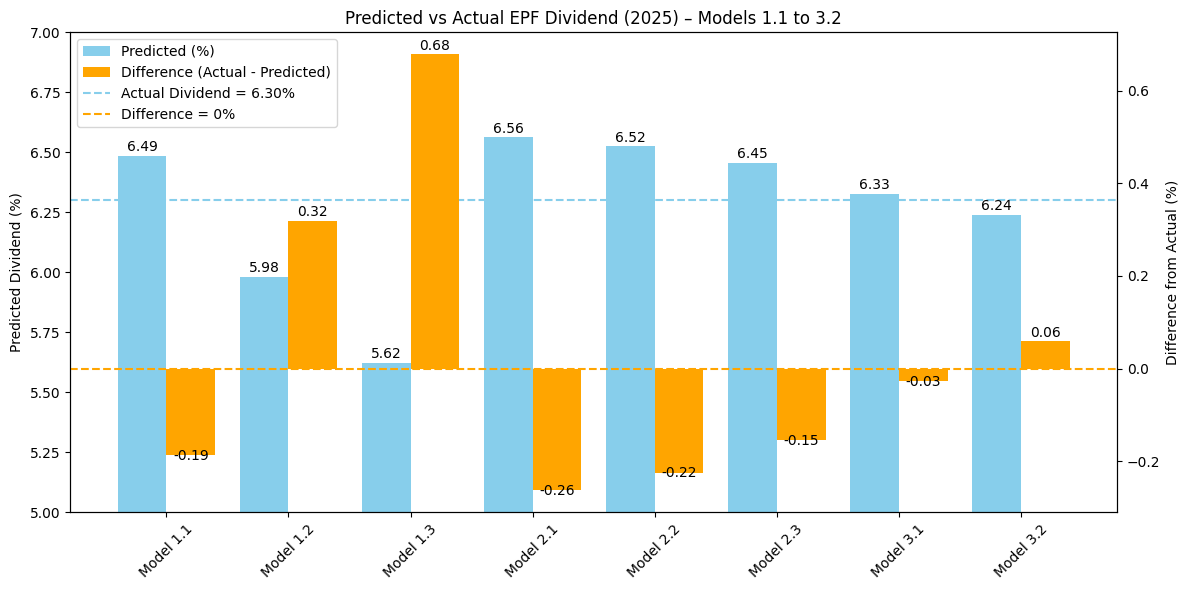

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Updated data
models = [
    'Model 1.1', 'Model 1.2', 'Model 1.3',
    'Model 2.1', 'Model 2.2', 'Model 2.3',
    'Model 3.1', 'Model 3.2'
]
predictions = [6.4864, 5.9809, 5.6214, 6.5624, 6.5241, 6.4547, 6.3271, 6.2406]
actual = 6.30
differences = [actual - pred for pred in predictions]

x = np.arange(len(models))  # Bar positions

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot predictions (left axis)
bar1 = ax1.bar(x - 0.2, predictions, width=0.4, color='skyblue')
ax1.set_ylabel('Dividend (%)')
ax1.set_ylim(5.0, 7.0)
ax1.axhline(y=actual, color='skyblue', linestyle='--', linewidth=1.5)

# X-axis ticks
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)

# Secondary axis for differences
ax2 = ax1.twinx()
bar2 = ax2.bar(x + 0.2, differences, width=0.4, color='orange')
ax2.set_ylabel('Difference from Actual (%)')
ax2.axhline(y=0, color='orange', linestyle='--', linewidth=1.5)

# Add value labels to predictions
for rect in bar1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 0.02, f'{height:.2f}', ha='center')

# Add value labels to differences
for rect in bar2:
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 0.01*np.sign(height), f'{height:.2f}', ha='center')

# Custom legend handles
custom_legend = [
    Patch(facecolor='skyblue', label='Predicted (%)'),
    Patch(facecolor='orange', label='Difference (Actual - Predicted)'),
    Line2D([0], [0], color='skyblue', linestyle='--', linewidth=1.5, label='Actual Dividend = 6.30%'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=1.5, label='Difference = 0%')
]

# Add combined legend
ax1.legend(handles=custom_legend, loc='upper left')

# Title and layout
plt.title('Predicted vs Actual EPF Dividend (2025) – Models 1.1 to 3.2')
plt.tight_layout()
plt.savefig("model_compare.png", dpi=500, bbox_inches='tight')
plt.show()

This chart compares predicted EPF dividends for 2025 across models 1.1 to 3.2, using both the predicted values (blue bars, left axis) and their differences from the actual known value of 6.30% (orange bars, right axis). Models 3.1 and 3.2 show the closest predictions, with minimal differences of –0.03% and +0.06%, respectively, suggesting they offer the most accurate forecasts. In contrast, Model 1.3 severely underpredicts the dividend at 5.62%, resulting in the largest error of +0.68%. Models 1.1, 2.1, and 2.2 slightly overpredict, while Model 1.2 underpredicts modestly. The chart effectively highlights which models align most closely with reality and which deviate significantly, offering a clear visual for selecting models based on forecasting accuracy.

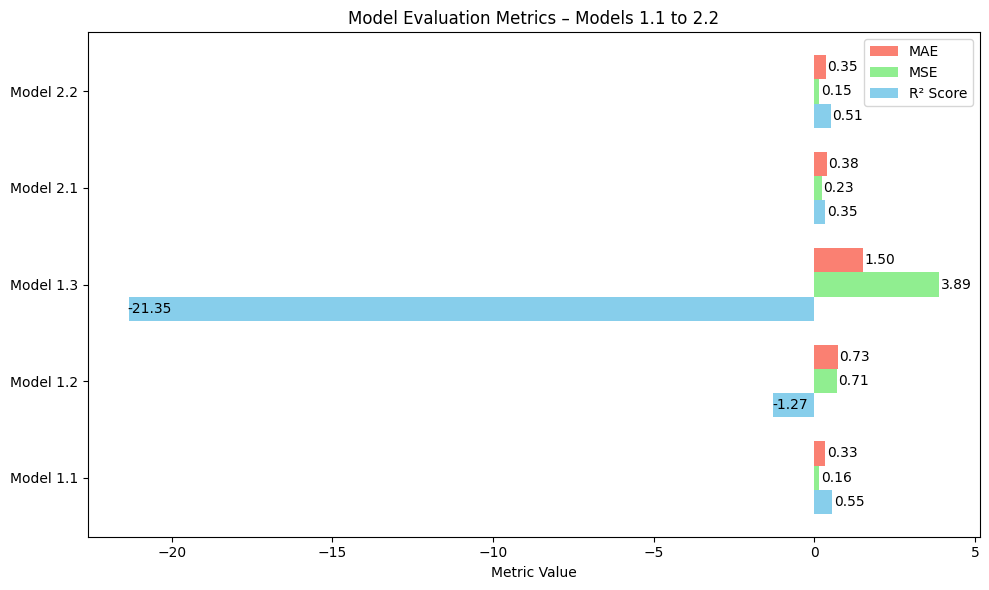

In [ ]:
# Model names and metrics
models = ['Model 1.1', 'Model 1.2', 'Model 1.3', 'Model 2.1', 'Model 2.2']
r2_scores = [0.5531, -1.2715, -21.3457, 0.3454, 0.5144]
mses = [0.1555, 0.7052, 3.8857, 0.2277, 0.1508]
maes = [0.3327, 0.7302, 1.5013, 0.3849, 0.3480]

y = np.arange(len(models))  # y positions
height = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal bars
bars1 = ax.barh(y - height, r2_scores, height, label='R² Score', color='skyblue')
bars2 = ax.barh(y, mses, height, label='MSE', color='lightgreen')
bars3 = ax.barh(y + height, maes, height, label='MAE', color='salmon')

# Labels and formatting
ax.set_yticks(y)
ax.set_yticklabels(models)
ax.set_xlabel("Metric Value")
ax.set_title("Model Evaluation Metrics – Models 1.1 to 2.2")
ax.legend(handles=[bars3, bars2, bars1], labels=['MAE', 'MSE', 'R² Score'])

# Optional: add value labels
for bars in [bars1, bars2, bars3]:
    for rect in bars:
        width = rect.get_width()
        ax.text(width + 0.05 * np.sign(width), rect.get_y() + rect.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig("metrics_comparison.png", dpi=500, bbox_inches='tight')
plt.show()

This chart compares five models across three key evaluation metrics: R² Score, Mean Squared Error (MSE), and Mean Absolute Error (MAE). Among the models, Model 1.1 performs best overall, with the highest R² (0.55) and lowest error metrics, indicating strong predictive power and minimal deviation from actual values. In contrast, Model 1.3 performs worst, with an extremely negative R² (–21.35), very high MSE (3.89), and large MAE (1.50), suggesting it fails to generalize and fits the training data poorly. Models 1.2, 2.1, and 2.2 fall in between: Model 2.2 stands out with a good balance of R² (0.51) and low errors, while Model 1.2 performs weakly. Overall, Model 1.1 and Model 2.2 emerge as the most reliable options.

## Conclusion

**Model 3.1:AR(1)**  gives us the best prediction among the seven models. It predicts a dividend rate of **6.35% in 2026**.